In [3]:
%matplotlib inline

import numpy as np
import theano.tensor as tt
import pymc3 as pm

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context('notebook')

/home/nilavro/irleak/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# 1 . Model Creation

In [4]:
with pm.Model() as model:
    # Model definition
    pass

In [5]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sd=1)
    obs = pm.Normal('obs', mu=mu, sd=1, observed=np.random.randn(100))

In [6]:
model.basic_RVs
model.free_RVs
model.observed_RVs
model.logp({'mu': 0})


array(-140.83633194)

In [7]:
%timeit model.logp({mu: 0.1})
logp = model.logp
%timeit logp({mu: 0.1})

62 ms ± 1.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
23.9 µs ± 241 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# 2. Probability Distributions 

In [8]:
help(pm.Normal)


Help on class Normal in module pymc3.distributions.continuous:

class Normal(pymc3.distributions.distribution.Continuous)
 |  Univariate normal log-likelihood.
 |  
 |  .. math::
 |  
 |     f(x \mid \mu, \tau) =
 |         \sqrt{\frac{\tau}{2\pi}}
 |         \exp\left\{ -\frac{\tau}{2} (x-\mu)^2 \right\}
 |  
 |  ========  ==========================================
 |  Support   :math:`x \in \mathbb{R}`
 |  Mean      :math:`\mu`
 |  Variance  :math:`\dfrac{1}{\tau}` or :math:`\sigma^2`
 |  ========  ==========================================
 |  
 |  Normal distribution can be parameterized either in terms of precision
 |  or standard deviation. The link between the two parametrizations is
 |  given by
 |  
 |  .. math::
 |  
 |     \tau = \dfrac{1}{\sigma^2}
 |  
 |  .. plot::
 |  
 |      import matplotlib.pyplot as plt
 |      import numpy as np
 |      import scipy.stats as st
 |      x = np.linspace(-5.0, 5.0, 1000)
 |      fig, ax = plt.subplots()
 |      f = lambda mu, sd : st.

In [9]:
dir(pm.distributions.mixture)


['Discrete',
 'Distribution',
 'Mixture',
 'Normal',
 'NormalMixture',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'all_discrete',
 'bound',
 'draw_values',
 'generate_samples',
 'get_tau_sd',
 'get_variable_name',
 'logsumexp',
 'np',
 'tt']

# Unobserved Random Variables

In [10]:
with pm.Model():
    x = pm.Normal('x', mu=0, sd=1)

In [11]:
x.logp({'x': 0})


array(-0.91893853)

# Observed Random Variables

In [13]:
with pm.Model():
    obs = pm.Normal('x', mu=0, sd=1, observed=np.random.randn(100))

# Deterministic transforms

In [14]:
with pm.Model():
    x = pm.Normal('x', mu=0, sd=1)
    y = pm.Gamma('y', alpha=1, beta=1)
    plus_2 = x + 2
    summed = x + y
    squared = x**2
    sined = pm.math.sin(x)

In [15]:
with pm.Model():
    x = pm.Normal('x', mu=0, sd=1)
    plus_2 = pm.Deterministic('x plus 2', x + 2)

# Automatic transforms of bounded RVs

In [16]:
with pm.Model() as model:
    x = pm.Uniform('x', lower=0, upper=1)

In [17]:
model.free_RVs


[x_interval__]

In [18]:
model.deterministics


[x]

In [19]:
with pm.Model() as model:
    x = pm.Uniform('x', lower=0, upper=1, transform=None)

print(model.free_RVs)

[x]


# Lists of RVs / higher-dimensional RVs

In [20]:
with pm.Model():
    x = [pm.Normal('x_{}'.format(i), mu=0, sd=1) for i in range(10)] # bad

In [21]:
with pm.Model() as model:
    x = pm.Normal('x', mu=0, sd=1, shape=10) # good

In [22]:
with model:
    y = x[0] * x[1] # full indexing is supported
    x.dot(x.T) # Linear algebra is supported

# Initialization with test_values

In [24]:
with pm.Model():
    x = pm.Normal('x', mu=0, sd=1, shape=5)

x.tag.test_value

array([0., 0., 0., 0., 0.])

In [25]:
with pm.Model():
    x = pm.Normal('x', mu=0, sd=1, shape=5, testval=np.random.randn(5))

x.tag.test_value

array([ 0.5594864 ,  0.05768278, -1.98709169, -1.83119469, -0.91678923])

# Inference

# MCMC Sampling

In [26]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sd=1)
    obs = pm.Normal('obs', mu=mu, sd=1, observed=np.random.randn(100))

    trace = pm.sample(1000, tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/nilavro/irleak/lib/python3.5/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]
  0%|          | 0/1500 [00:00<?, ?it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '6433' (I am process '6435')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/nilavro/.theano/compiledir_Linux-4.13--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '6433' (I am process '6436')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/nilavro/.theano/compiledir_Linux-4.13--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64

(array([  4.,   5.,  18.,  42.,  75., 134., 226., 340., 398., 466., 544.,
        538., 419., 361., 203., 116.,  64.,  32.,   7.,   8.]),
 array([-0.37967573, -0.34539079, -0.31110585, -0.27682091, -0.24253597,
        -0.20825103, -0.17396609, -0.13968115, -0.10539621, -0.07111127,
        -0.03682633, -0.00254139,  0.03174355,  0.06602849,  0.10031343,
         0.13459837,  0.16888331,  0.20316825,  0.23745319,  0.27173813,
         0.30602307]),
 <a list of 20 Patch objects>)

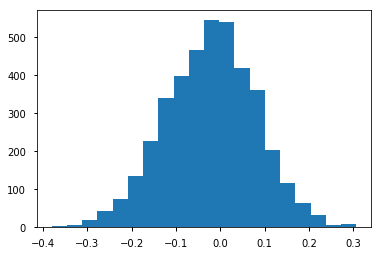

In [29]:
plt.hist(trace['mu'] ,  20)

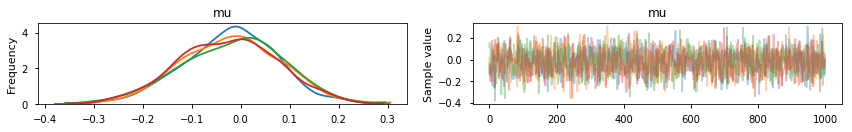

In [30]:
pm.traceplot(trace);


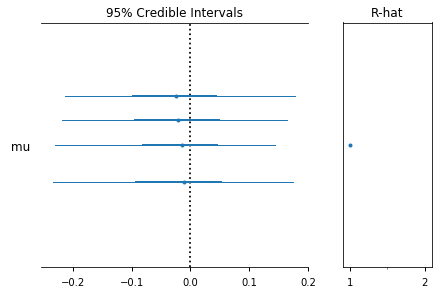

In [31]:
pm.forestplot(trace);


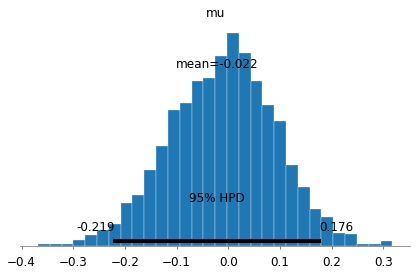

In [34]:
pm.plot_posterior(trace) 


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/nilavro/irleak/lib/python3.5/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]
100%|██████████| 1000/1000 [00:01<00:00, 510.71it/s]


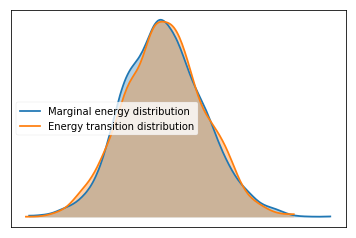

In [35]:
with pm.Model() as model:
    x = pm.Normal('x', mu=0, sd=1, shape=100)
    trace = pm.sample(cores=4)

pm.energyplot(trace);

# Variational Inference 

In [37]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sd=1)
    sd = pm.HalfNormal('sd', sd=1)
    obs = pm.Normal('obs', mu=mu, sd=sd, observed=np.random.randn(100))

    approx = pm.fit()

Average Loss = 137.01: 100%|██████████| 10000/10000 [00:03<00:00, 3204.18it/s]
Finished [100%]: Average Loss = 137.01


In [38]:
approx.sample(500)


<MultiTrace: 1 chains, 500 iterations, 3 variables>

In [39]:
mu = pm.floatX([0., 0.])
cov = pm.floatX([[1, .5], [.5, 1.]])
with pm.Model() as model:
    pm.MvNormal('x', mu=mu, cov=cov, shape=2)
    approx = pm.fit(method='fullrank_advi')

Average Loss = 0.0068883: 100%|██████████| 10000/10000 [00:06<00:00, 1443.47it/s]
Finished [100%]: Average Loss = 0.0065707


In [40]:
with pm.Model() as model:
    pm.MvNormal('x', mu=mu, cov=cov, shape=2)
    approx = pm.FullRankADVI().fit()

Average Loss = 0.01127: 100%|██████████| 10000/10000 [00:07<00:00, 1416.01it/s] 
Finished [100%]: Average Loss = 0.011343


/home/nilavro/irleak/lib/python3.5/site-packages/seaborn/distributions.py:645: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


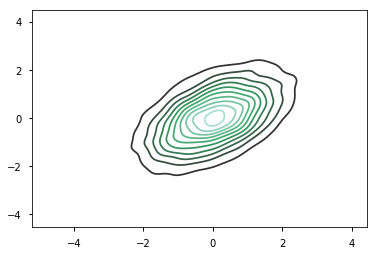

In [41]:
plt.figure()
trace = approx.sample(10000)
sns.kdeplot(trace['x'])